In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from numpy.linalg import svd
from numpy.linalg import cond
from numpy.linalg import matrix_rank

In [2]:
# !pip install autograd

### Example: 3.2

In [3]:
def model_mat(t, T0, del_t):
    
    """
    Function to generate a model matrix
    
    Parameters
    ----------
    t: time (array)
    T0: reference time (s)
    del_t: time interval (s)
    
    Returns
    -------
    model matrix: G
    
    """
    
    G = np.zeros((len(t), len(t)))
    
    for i in range(len(t)):
        
        for j in range(len(t)):
            
            if(t[i] >= t[j]):
        
                G[i,j] = (t[i]-t[j]) * (1/T0) * np.exp(1) * np.exp(-(t[i]-t[j])/T0) * del_t
            
            else:
                
                G[i,j] = 0         
    return G

def gen_inverse_sol(U, S, VT, data):
    
    """
    Function to calculate generalized inverse solution based on SVD
    
    Parameters
    ----------
    U: Left singular vectors
    S: singular values array
    VT: Right singular vectors
    data: data
    
    Returns
    -------
    sol: generalized inverse solution 
    
    """
    coeff = np.matmul(np.matmul(VT.T, np.linalg.inv(np.diag(S))), U.T)
    sol = np.matmul(coeff, data)
    
    return sol

def TSVD_sol(U, S, VT, data, p):
        
    """
    Function to calculate generalized inverse solution using truncated SVD (TSVD)
    
    Parameters
    ----------
    U: Left singular vectors
    S: singular values array
    VT: Right singular vectors
    data: data
    p: cut number
    
    Returns
    -------
    sol: generalized inverse solution 
    
    """
    sol = np.zeros(len(data))

    for i in range(p):
    
        sol += np.matmul(np.matmul(U[:,i].T, d_noisy)/S[i], \
                                             VT.T[:,i].reshape(1, len(data)))
    return sol
    

In [4]:
del_t = 0.5
T0 = 10
t = np.linspace(-5, 100, 210, endpoint=True)
G = model_mat(t, T0, del_t)

#-- performing SVD ---
U, S, VT = svd(G)
print('condition number: {}'.format(S[0]/S[-2]))

condition number: 1468.4030153084686


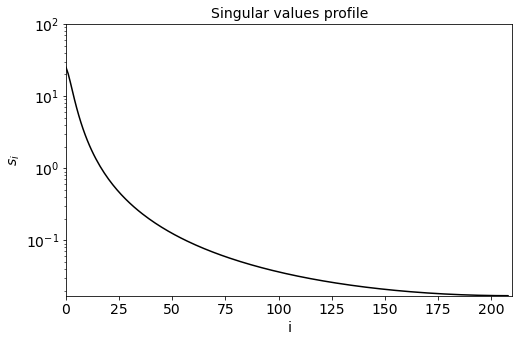

In [5]:
plt.figure(figsize=(8,5))

plt.semilogy(S, c='k')
plt.xlim(0, 210)
plt.ylim(1.7e-2, 1e2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('i', fontsize=14)
plt.ylabel(r'$s_i$', fontsize=14)
plt.title('Singular values profile', fontsize=14)
plt.show()

In [6]:
np.random.seed(0)
pulse_width = 2

#-- true model ---
m_true = np.exp(-(t-8)**2 / (2*pulse_width**2)) + \
                                0.5 * np.exp(-(t-25)**2 / (2*pulse_width**2))

#-- noiseless data using true model ---
d_true = np.matmul(G, m_true.reshape(len(m_true), 1))

#-- noisey data ---
d_noisy = d_true + 0.05* np.random.randn(len(m_true)).reshape(len(m_true), 1)

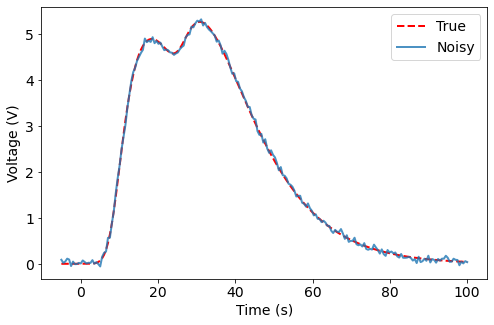

In [7]:
plt.figure(figsize=(8,5))

plt.plot(t, d_true, ls='--', c='r', lw=2, label='True')
plt.plot(t, d_noisy, lw=2, alpha=0.8, label='Noisy')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Voltage (V)', fontsize=14)
plt.legend(fontsize=14)
plt.show()

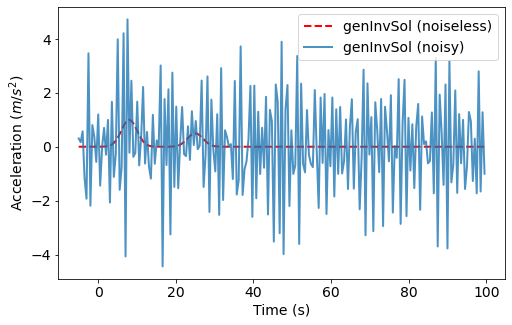

In [8]:
#-- generalized inverse solution ---
m_ginvsol_true = gen_inverse_sol(U, S, VT, d_true) # using true data
m_ginvsol_noise = gen_inverse_sol(U, S, VT, d_noisy) # using noisy data

plt.figure(figsize=(8,5))

plt.plot(t[0:-1], m_ginvsol_true[0:-1], ls='--', c='r', lw=2, label='genInvSol (noiseless)')
plt.plot(t[0:-1], m_ginvsol_noise[0:-1], lw=2, alpha=0.8, label='genInvSol (noisy)')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel(r'Acceleration ($m/s^2$)', fontsize=14)
plt.legend(fontsize=14)
plt.show()

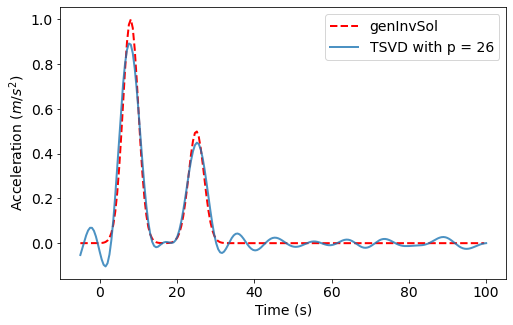

In [9]:
p = 26

m_TSVD_noisy = TSVD_sol(U, S, VT, d_noisy, p)

plt.figure(figsize=(8,5))

plt.plot(t[0:-1], m_ginvsol_true[0:-1], ls='--', c='r', lw=2, label='genInvSol')
plt.plot(t, m_TSVD_noisy, lw=2, alpha=0.8, label='TSVD with p = %d'%p)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel(r'Acceleration ($m/s^2$)', fontsize=14)
plt.legend(fontsize=14)
plt.show()

With a tradeoff of oscillations in the solution and loss of resolution, 
the TSVD technique resolves the essential features of the true model.

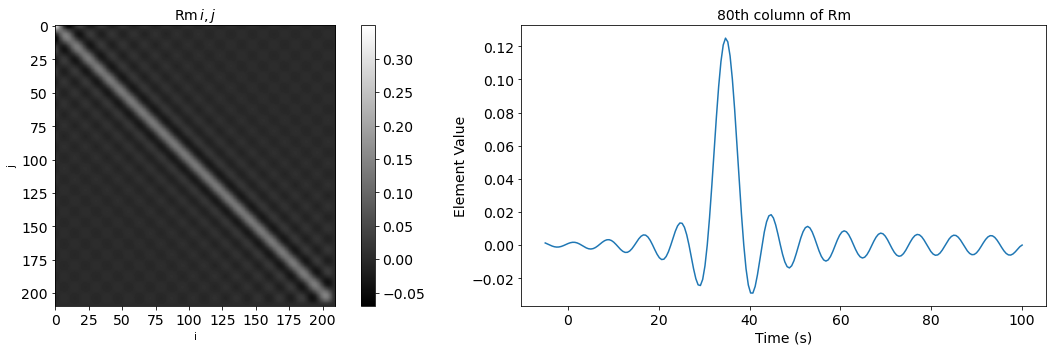

In [10]:
#-- Model resolution matrix ---
R_m = np.matmul(VT.T[:,:p], VT.T[:,:p].T)

plt.figure(figsize=(16,5))

plt.subplot(121)
plt.imshow(R_m, cmap='gist_gray')
plt.xlabel('i')
plt.ylabel('j')
plt.title(r'Rm$\,{i,j}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.colorbar().ax.tick_params(labelsize=14)

plt.subplot(122)
plt.plot(t, R_m[:,79])
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Element Value', fontsize=14)
plt.title(r'80th column of Rm', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

### Example: 3.3


In [11]:
def model_matrix_shaw(m, n):
    
    """
    Function to generate a model matrix of shaw problem
    
    Parameters
    ----------
    m: number of rows
    n: number of columns
    
    Returns
    -------
    s, theta, model matrix
    
    """
        
    del_theta = np.pi/n
    
    G = np.zeros((m, n))
    s = np.zeros(m)
    theta = np.zeros(n)
    
    for i in range(m):
        
        s[i] = (i - 0.5)*np.pi / m - np.pi/2  

        for j in range(n):
            
            theta[j] = (j - 0.5)*np.pi / n - np.pi/2
            
            if((np.pi*(np.sin(s[i]) + np.sin(theta[j]))) == 0):
                
                G[i,j] = (np.cos(s[i]) + np.cos(theta[j]))**2 * del_theta
                
            else:
                
                G[i,j] = (np.cos(s[i]) + np.cos(theta[j]))**2 * ((np.sin(np.pi*(np.sin(s[i]) + 
                                                np.sin(theta[j]))))/(np.pi*(np.sin(s[i]) + 
                                                np.sin(theta[j]))))**2 * del_theta
    return s, theta, G

In [12]:
#-- generating model matrix ---
m, n = 20, 20
s, theta, G_model_shaw = model_matrix_shaw(m, n)

#-- performing SVD on model matrix ---
U, S, VT = svd(G_model_shaw)

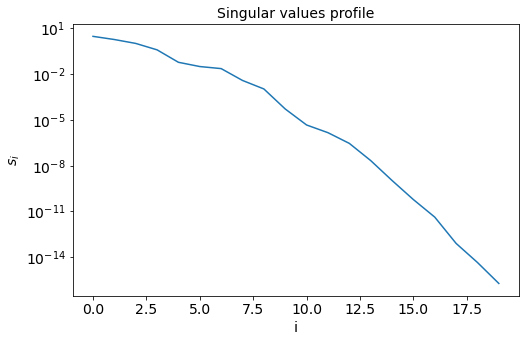

In [13]:
plt.figure(figsize=(8, 5))

plt.semilogy(S)
plt.ylabel(r'$s_i$', fontsize=14)
plt.xlabel(r'i', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Singular values profile', fontsize=14)

plt.show()

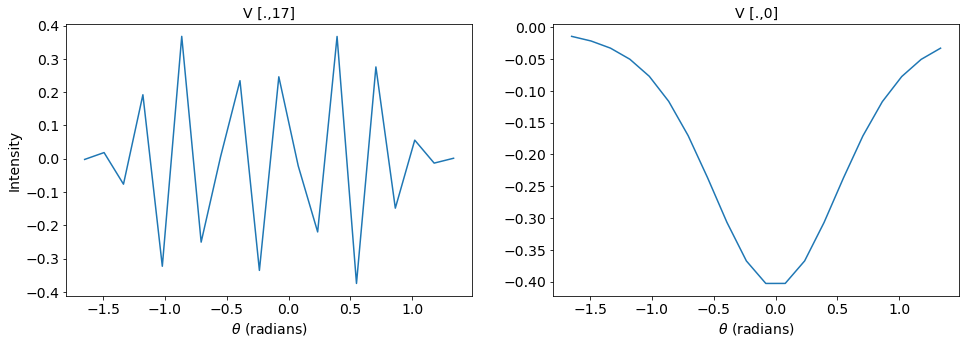

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

ax1.plot(theta, VT.T[:,17])
ax1.set_xlabel(r'$\theta$ (radians)', fontsize=14)
ax1.set_ylabel(r'Intensity', fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
ax1.set_title(r'V [.,17]', fontsize=14)

ax2.plot(theta, VT.T[:,0])
ax2.set_xlabel(r'$\theta$ (radians)', fontsize=14)
ax2.tick_params(axis='both', labelsize=14)
ax1.set_ylabel(r'Intensity', fontsize=14)
ax2.set_title(r'V [.,0]', fontsize=14)

plt.show()

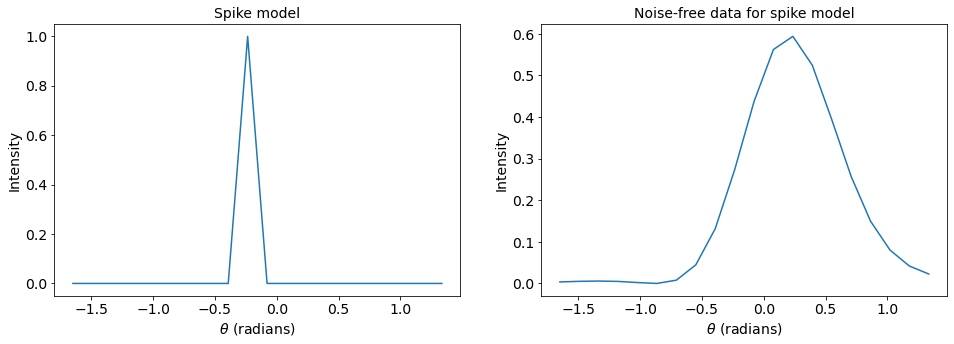

In [15]:
#-- input to the system ---
model = np.zeros(n).reshape(n,1)
model[9,0] = 1

#-- data generation ---
np.random.seed(0)
sigma = 1e-6  # std of noise
d_true = G_model_shaw@model  # true data
d_noisy = d_true + (sigma * np.random.randn(n)).reshape(n,1) # noisy data ~ d_true + 
                                                                            # N(0, sigma)
plt.figure(figsize=(16, 5))

plt.subplot(121)
plt.plot(theta, model)
plt.xlabel(r'$\theta$ (radians)', fontsize=14)
plt.ylabel(r'Intensity', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title('Spike model', fontsize=14)

plt.subplot(122)
plt.plot(theta, d_true)
plt.xlabel(r'$\theta$ (radians)', fontsize=14)
plt.ylabel(r'Intensity', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title('Noise-free data for spike model', fontsize=14)

plt.show()

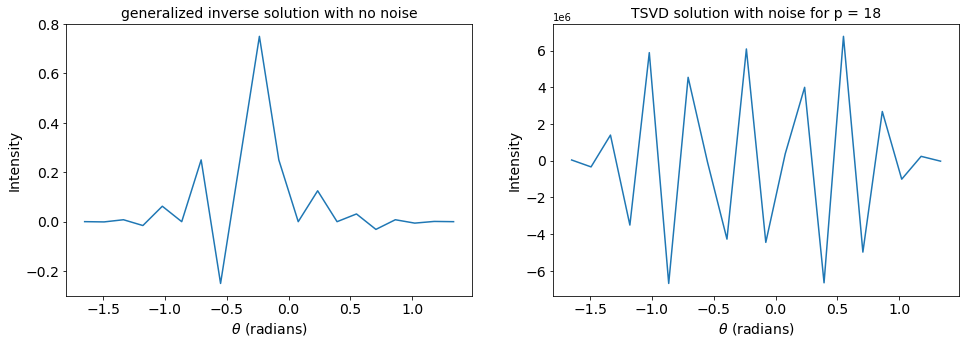

In [16]:
p = 18
m_ginvsol_true = gen_inverse_sol(U, S, VT, d_true) # gen inverse solution (noise-free)
m_ginvsol_noisy = TSVD_sol(U, S, VT, d_noisy, p)  # TSVD solution with noise for p = 18

plt.figure(figsize=(16, 5))

plt.subplot(121)
plt.plot(theta, m_ginvsol_true)
plt.xlabel(r'$\theta$ (radians)', fontsize=14)
plt.ylabel(r'Intensity', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title('generalized inverse solution with no noise', fontsize=14)

plt.subplot(122)
plt.plot(theta, m_ginvsol_noisy)
plt.xlabel(r'$\theta$ (radians)', fontsize=14)
plt.ylabel(r'Intensity', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title('TSVD solution with noise for p = 18', fontsize=14)

plt.show()

From the above plots, we can see that the solution is prose to even very small noise.

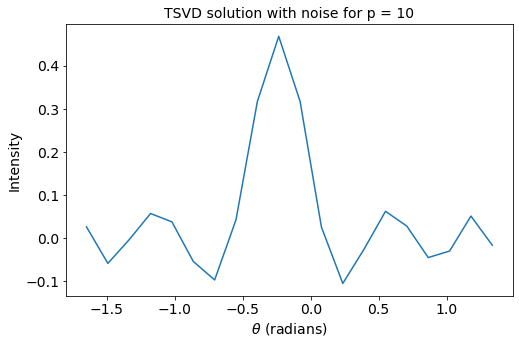

In [17]:
p = 10
m_ginvsol_noisy = TSVD_sol(U, S, VT, d_noisy, p)  # TSVD solution with noise for p = 18

plt.figure(figsize=(8, 5))

plt.plot(theta, m_ginvsol_noisy)
plt.xlabel(r'$\theta$ (radians)', fontsize=14)
plt.ylabel(r'Intensity', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title('TSVD solution with noise for p = 10', fontsize=14)

plt.show()

Taking a smaller cut value (p=10), we recover some significant spike feature. However we lose the model resolution.

### Example 3.3 with Tikhonov Regularization

$(G^T G + \alpha^2 I)\, m = G^T d$  (Zeroth-order Tikhonov Regularization solution of $Gm = d$)
$\newline$
$m_{\alpha} = \sum_{i=1}^{k} f_i\frac{U_{.,i}^T\, d}{s_i}\, V_{.,i}$,  where $f_i = \frac{s_i^2}{s_i^2 + \alpha^2}$ are known as filter factors.

In [18]:
def TikhonovReg_SVDsol(alpha, U, S, VT, data):
    
    """
    Function to calculate zeroth-order Tikhonov Regularized SVD solution
    
    Parameters
    ----------
    alpha: Regularization parameter
    U: Left singular vectors
    S: singular values array
    VT: Right singular vectors (transpose)
    data: data
    
    Returns
    -------
    sol: generalized inverse solution 
    
    """
    m = np.zeros(len(data))
    k = min(np.diag(S).shape)

    for i in range(k):
    
        m += S[i]**2/(S[i]**2 + alpha**2) * np.matmul(np.matmul(U[:,i].T, d_noisy)/S[i], \
                                                                    VT.T[:,i].reshape(1, len(data)))
    return m


Model norm corresponding to L-curve alpha value: 0.6888457842762686
Model norm corresponding to discrepancy principle alpha value: 0.662165878418536


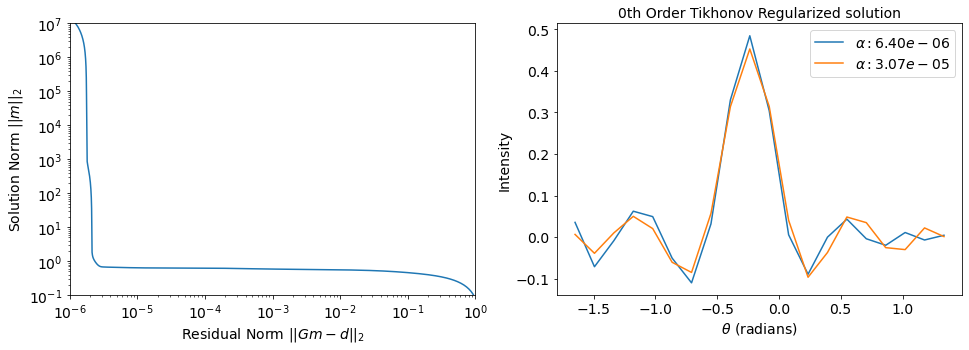

In [19]:
N = 1000
alpha = np.logspace(-16, 1, N)
m_norm = np.empty(N)
Res_norm = np.empty(N)

for i in range(N):
    
    m = TikhonovReg_SVDsol(alpha[i], U, S, VT, d_noisy)
    Res_norm[i] = np.linalg.norm(G_model_shaw@m.reshape(len(m),1) - d_noisy)
    m_norm[i] = np.linalg.norm(m)
       
# f1 = np.gradient(m_norm)
# f2 = np.gradient(f1)
# curvature = abs(f1)/(1 + f2**2)**(1.5)
# alpha_L = alpha[np.argmax(curvature)]
alpha_L = 6.4*1e-6

# -- value of alpha Residual norm approx m**1/2 * sigma, where sigma is stand dev. of the 
                                                                # noise added in the true data ---
idx = np.where(Res_norm >= np.sqrt(20)*1e-6)[0][0]
alpha_discPrinc = alpha[idx]

#-- Tikhonov Regularized solution with alpha determined from L curve and Discrepancy principle ---
m_TKRsol = TikhonovReg_SVDsol(alpha_L, U, S, VT, d_noisy)
Res_norm_TKRSol = np.linalg.norm(m_TKRsol)
m_discPrinc = TikhonovReg_SVDsol(alpha_discPrinc, U, S, VT, d_noisy)
Res_norm_discPrinc = np.linalg.norm(m_discPrinc)

print('Model norm corresponding to L-curve alpha value: {}'.format(Res_norm_TKRSol))
print('Model norm corresponding to discrepancy principle alpha value: {}'.format(Res_norm_discPrinc))

plt.figure(figsize=(16,5))

plt.subplot(121)
plt.loglog(Res_norm, m_norm)
plt.xlabel(r'Residual Norm $||Gm - d||_2$', fontsize=14)
plt.ylabel(r'Solution Norm $||m||_2$', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.xlim(1e-6, 1e0)
plt.ylim(1e-1, 1e7)

plt.subplot(122)
plt.plot(theta, m_TKRsol, label=r'$\alpha: %.2e$'%alpha_L)
plt.plot(theta, m_discPrinc, label=r'$\alpha: %.2e$'%alpha_discPrinc)
plt.xlabel(r'$\theta$ (radians)', fontsize=14)
plt.ylabel(r'Intensity', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=14)
plt.title(r'0th Order Tikhonov Regularized solution',fontsize=14)

plt.show()

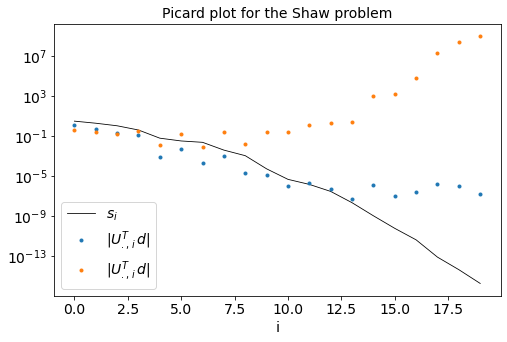

In [20]:
val1 = np.empty(len(d_noisy))
val2 = np.empty(len(d_noisy))

for i in range(len(d_noisy)):
    
    val1[i] = abs(U[:,i].T@d_noisy)
    val2[i] = abs(U[:,i].T@d_noisy)/S[i]

plt.figure(figsize=(8,5))

plt.semilogy(S, c='k', lw=0.8, label=r'$s_i$')
plt.semilogy(val1, '.', label=r'$|U_{.,i}^T\, d|$')
plt.semilogy(val2, '.', label=r'$|U_{.,i}^T\, d|$')
plt.xlabel('i', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title('Picard plot for the Shaw problem', fontsize=14)

plt.legend(fontsize=14, loc=3)
plt.show()

#### Model resolution matrix 
$R_m = VFV^T$
#### Data resolution matrix
$R_d = UFU^T$

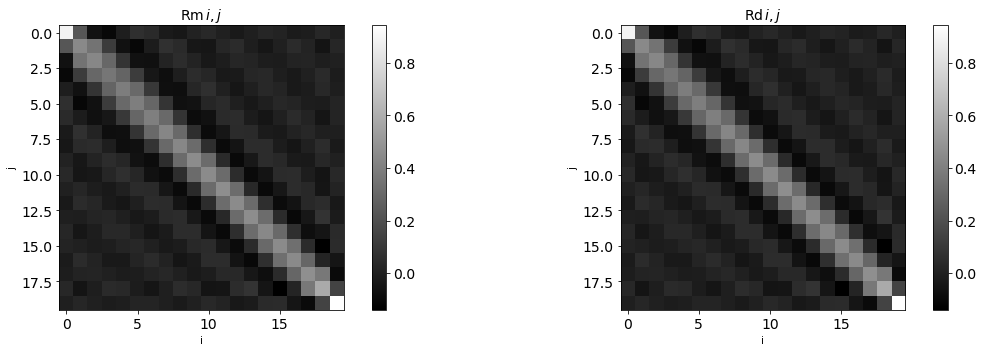

In [21]:
F = np.diag(S**2/(S**2 + alpha_discPrinc**2))
R_m = (VT.T@F)@VT
R_d = (U@F)@U.T

plt.figure(figsize=(16,5))

plt.subplot(121)
plt.imshow(R_m, cmap='gist_gray')
plt.xlabel('i')
plt.ylabel('j')
plt.title(r'Rm$\,{i,j}$', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.colorbar().ax.tick_params(labelsize=14)

plt.subplot(122)
plt.imshow(R_d, cmap='gist_gray')
plt.xlabel('i')
plt.ylabel('j')
plt.title(r'Rd$\,{i,j}$', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.colorbar().ax.tick_params(labelsize=14)

plt.tight_layout()

plt.show()